smart_hans_07252022_154259_11_395-432_08_mgy_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_07252022_155048_13_482-523_08_mny_.csv
smart_hans_07252022_155230_11_402-439_08_mgy_.csv
smart_hans_07312022_160010_5_109-124_08_mny_x.csv
smart_hans_07312022_161226_7_250-280_08_mgy_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_07312022_162132_5_146-170_08_mny_.csv
smart_hans_07312022_162305_9_246-269_08_mny_.csv
smart_hans_07312022_162745_8_272-303_08_mgy_.csv
smart_hans_07312022_164319_11_363-393_08_mny_.csv
smart_hans_07312022_164533_9_305-333_08_mgy_.csv
smart_hans_07312022_164702_5_181-209_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_07312022_165851_12_402-433_08_mgy_.csv
smart_hans_07312022_170052_6_215-244_08_mgy_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_07312022_170549_7_197-222_08_mnn_.csv
smart_hans_07312022_171246_5_174-198_08_mnn_.csv
smart_hans_07312022_171406

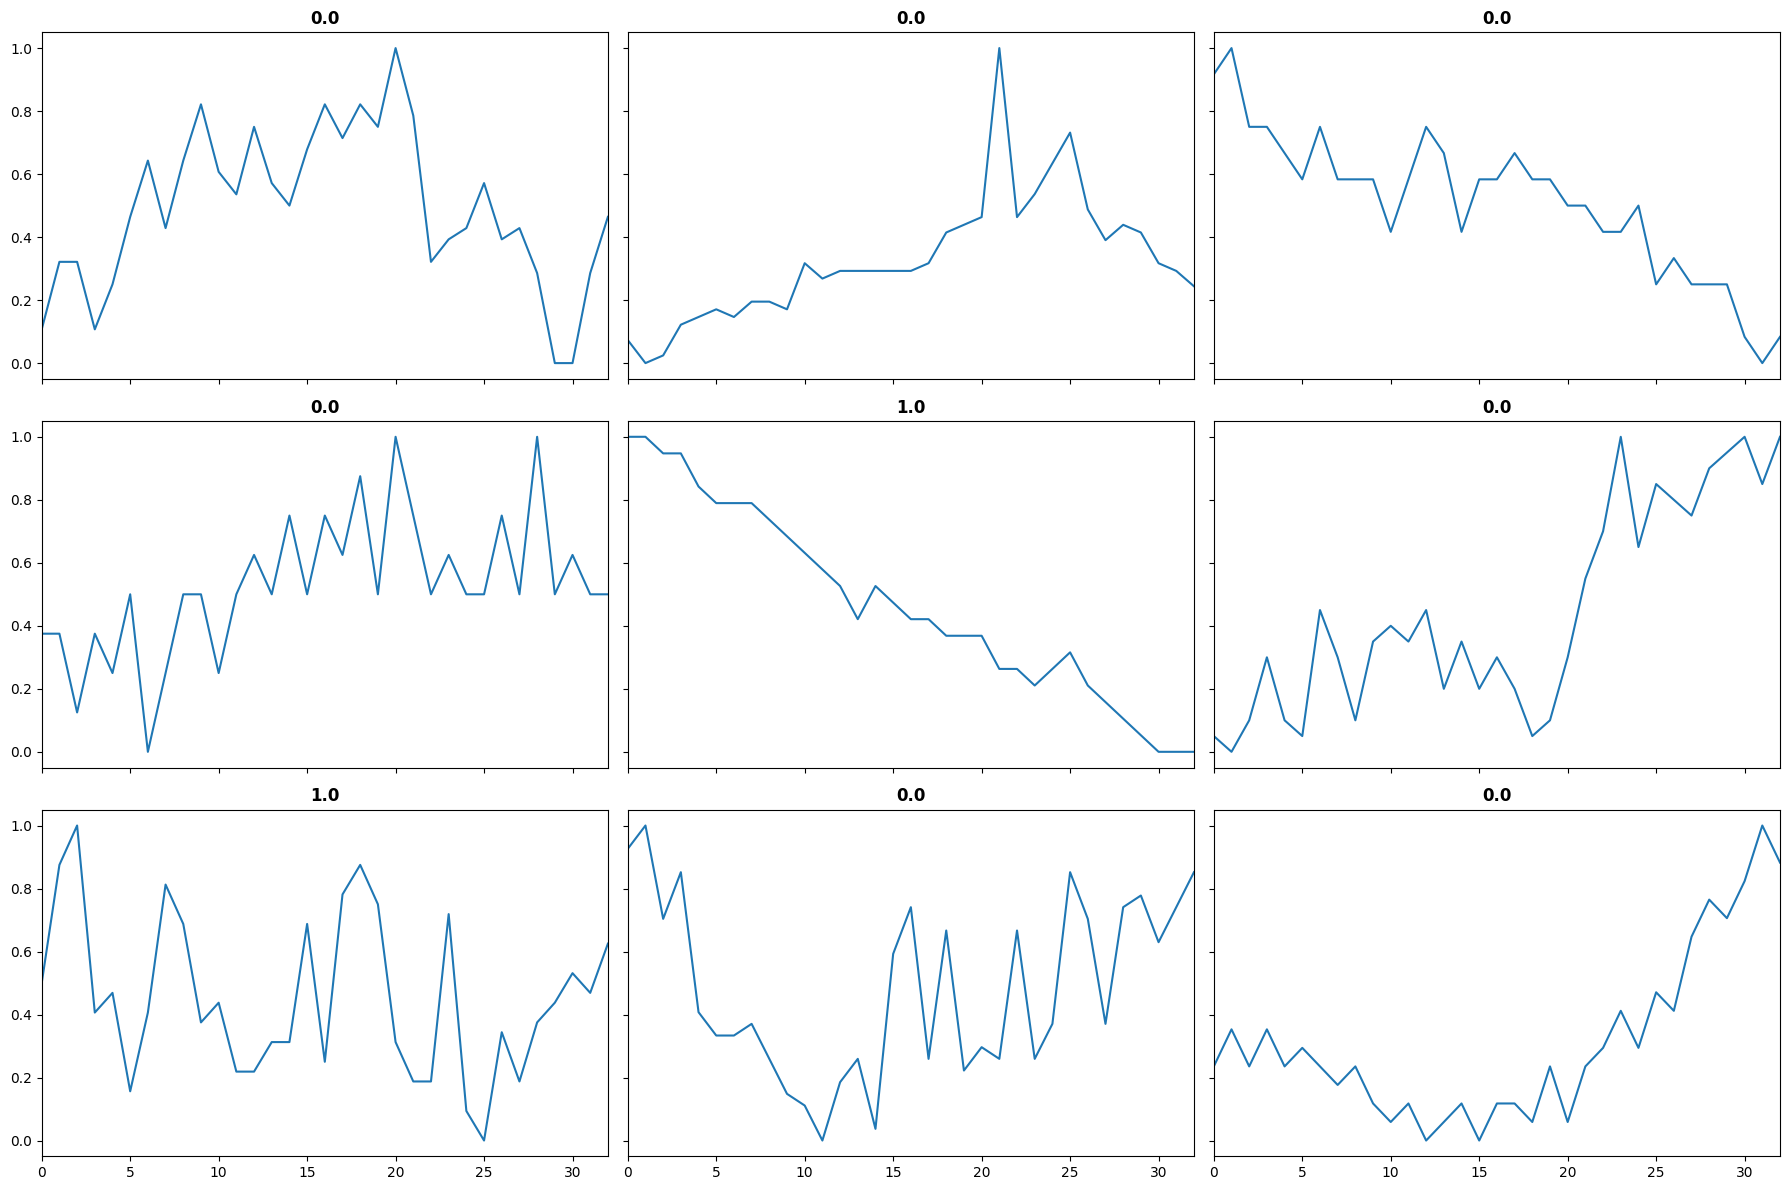

In [43]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

num_scenario = 4

nr_taps = 1

tap_size = 33

move_by = -5

learning_cycles = 10

model_to_use = "InceptionTimePlus"

threshold = 0.51

features_to_learn_with = ["chin_x"]
feature_list_string = '_'.join(features_to_learn_with)

models_folder = "models"
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="C:/Users/adi/Nextcloud/smart_hans/AP2/Daten/zum_sichten/laeuft", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=features_to_learn_with)
train, test, df= dl.train, dl.test, dl.df

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,  num_workers=0)

print(df.shape)
dls.show_batch(sharey=True)

In [44]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    nf = trial.suggest_categorical('num_filters', [6, 12, 24, 48]) # search through all categorical values in the provided list
    depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    
    learn = TSClassifier(X, y, splits=splits,
                         arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate, 'depth':depth},
                         metrics=accuracy, cbs=FastAIPruningCallback(trial))


    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1]

In [45]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2022-10-22 18:21:32,130] A new study created in memory with name: no-name-52593da7-2fae-4d6d-9874-fd8c0c692c1c
[I 2022-10-22 18:21:32,340] Trial 0 finished with value: 0.6948378682136536 and parameters: {'num_filters': 12, 'depth': 3, 'dropout_rate': 0.5, 'learning_rate': 0.0021378509750897864}. Best is trial 0 with value: 0.6948378682136536.
[I 2022-10-22 18:21:33,174] Trial 1 finished with value: 0.688677966594696 and parameters: {'num_filters': 48, 'depth': 3, 'dropout_rate': 0.2, 'learning_rate': 1.132249342324597e-05}. Best is trial 1 with value: 0.688677966594696.
[I 2022-10-22 18:21:33,477] Trial 2 finished with value: 0.6824970245361328 and parameters: {'num_filters': 6, 'depth': 6, 'dropout_rate': 0.1, 'learning_rate': 0.0001375274977482373}. Best is trial 2 with value: 0.6824970245361328.
[I 2022-10-22 18:21:34,056] Trial 3 finished with value: 0.6880226731300354 and parameters: {'num_filters': 12, 'depth': 9, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0068711

In [46]:


print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.6788074374198914
  Params: 
    num_filters: 6
    depth: 3
    dropout_rate: 0.2
    learning_rate: 0.0009645888166813989


In [47]:


display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))



In [48]:


# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
nf = trial.params['num_filters']
depth = trial.params['depth']
dropout_rate = trial.params['dropout_rate']
learning_rate = trial.params['learning_rate']



epoch,train_loss,valid_loss,accuracy,time
0,0.706461,0.685517,0.572917,00:00
1,0.709556,0.685328,0.572917,00:00
2,0.707917,0.685640,0.572917,00:00
3,0.700207,0.686123,0.572917,00:00
4,0.699297,0.686701,0.572917,00:00
5,0.694558,0.687349,0.572917,00:00
6,0.690174,0.688001,0.572917,00:00
7,0.687814,0.688501,0.583333,00:00
8,0.684784,0.688898,0.572917,00:00
9,0.683056,0.689111,0.500000,00:00


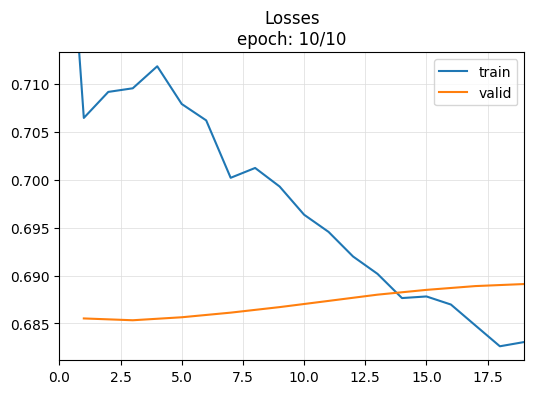

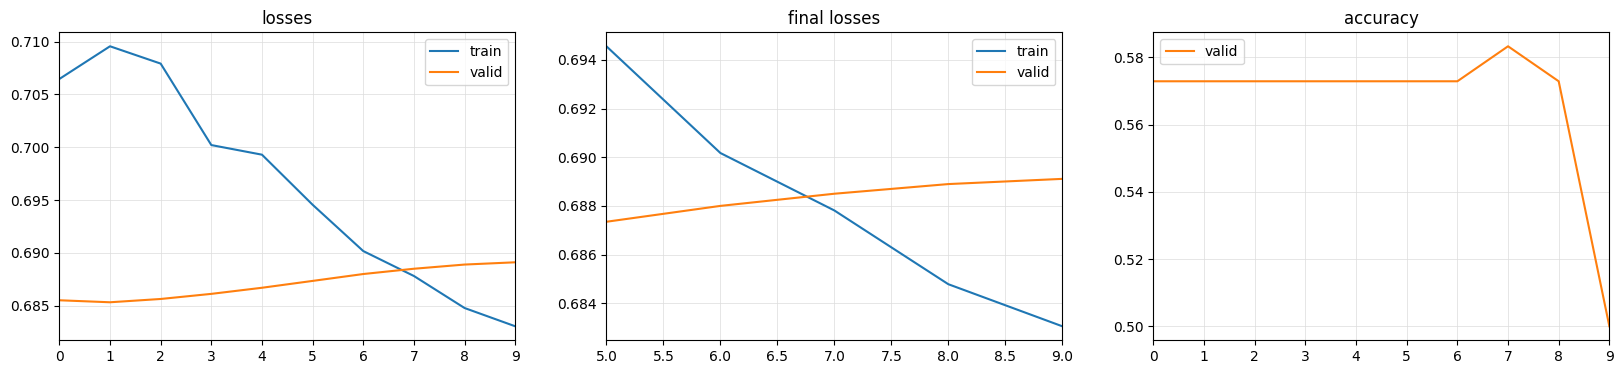

In [49]:


learn = TSClassifier(X, y, splits=splits, 
                     batch_tfms=TSStandardize(by_sample=True), 
                     arch=InceptionTimePlus, arch_config={'nf':nf, 'fc_dropout':dropout_rate, 'depth':depth},
                     metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=learning_rate)


not enough values to plot a chart


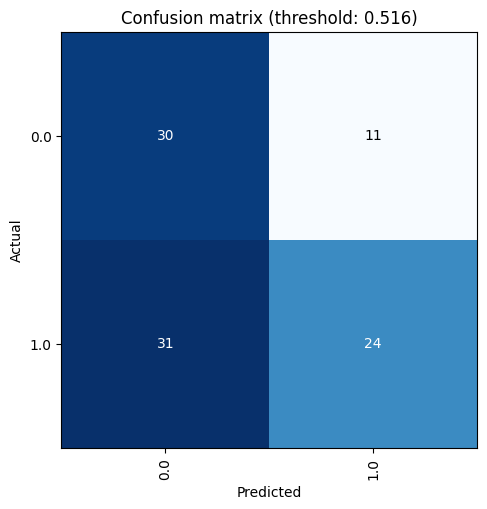

In [55]:
learn.recorder.plot_metrics()
learn.plot_confusion_matrix(thr=0.516)
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),feature_list_string,learning_cycles, current_time)